In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

from statsmodels.stats import proportion
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams["font.size"] = 18

## Create some fake data

Create a fake dataset, simulating a fake a/b test

In [211]:
# Change these parameters to test different significants
group_a_size = 1000
group_a_probs = [0.6, 0.4]

group_b_size = 1100
group_b_probs = [0.45, 0.55]

In [212]:
outcomes = ['Success', 'Failure']

group_a = np.random.choice(outcomes, size=group_a_size, p=group_a_probs)
group_b = np.random.choice(outcomes, size=group_b_size, p=group_b_probs)

experiment_results = pd.DataFrame({
    'Outcome': np.concatenate([group_a, group_b]), 
    'Group':np.concatenate([['A']*len(group_a), ['B']*len(group_b)])
                                })

## Let's explore the data generated

In [213]:
pd.crosstab(experiment_results.Group, experiment_results.Outcome, margins=True)

Outcome,Failure,Success,All
Group,,,
A,417,583,1000
B,606,494,1100
All,1023,1077,2100


In [214]:
experiment_results.groupby('Group').Outcome.value_counts(normalize=True).unstack().style.format("{:.2%}")

Outcome,Failure,Success
Group,,
A,41.70%,58.30%
B,55.09%,44.91%


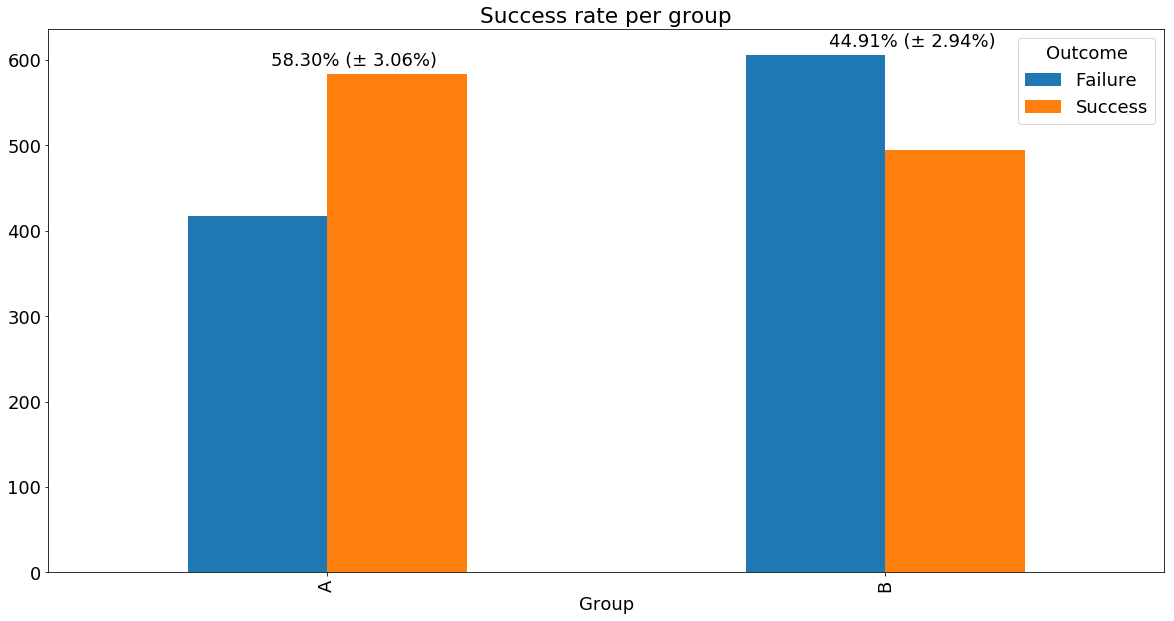

In [215]:
data = experiment_results.groupby(['Group','Outcome']).size().unstack()
ax = data.plot(kind='bar')
ax.set_title('Success rate per group')

success_rates = experiment_results.groupby('Group').Outcome.value_counts(normalize=True).unstack()['Success']

for index, rate in enumerate(success_rates):
    low_CI, upper_CI = proportion.proportion_confint(data.iloc[index]['Success'], data.iloc[index].sum())
    ax.text(index - 0.1, data.iloc[index].max() + 10, '{:.2%} (± {:.2%})'.format(rate, (upper_CI-low_CI)/2))

## Checking if results are statistically significant
Assuming that the data is real data, how can we test if the results are statistically significant? 
There are a few way to do this, I will explore three here.

**Method 1:**
In the case of just two variants, the first method to verify statstical significance is to make sure that the the confidence interval calculated above are not overlapping!

In [216]:
variant_mean = None
for index_label, row in data.iterrows():
    low_CI, upper_CI = proportion.proportion_confint(row['Success'], row.sum())
    if variant_mean is None:
        variant_mean = (low_CI + upper_CI)/2
        winning_variant_low_CI = low_CI
        winning_variant_upper_CI = upper_CI
    else: 
        if variant_mean < (low_CI + upper_CI)/2:
            losing_variant_low_CI = winning_variant_low_CI
            losing_variant_upper_CI = winning_variant_upper_CI
            
            winning_variant_low_CI = low_CI
            winning_variant_upper_CI = upper_CI
            
            variant_mean = (low_CI + upper_CI)/2
        else:
            losing_variant_low_CI = low_CI
            losing_variant_upper_CI = upper_CI
            
            variant_mean = (low_CI + upper_CI)/2
            
if winning_variant_low_CI > losing_variant_upper_CI:
    print('Results are significant!')
else:
    print('Results are not significant!')

Results are significant!


**Method 2:** Chi-square test of independence of variables in a contingency table. This method generalise for more than one variant. If the numver of observation is small (less than 50 in total) then use fisher_exact

In [217]:
obs = pd.crosstab(experiment_results.Group, experiment_results.Outcome).values
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)

if p < 0.05:
    print('Results are significant! chi-value: {} p-value: {}'.format(chi2, p))
else:
    print('Results are not significant! chi-value: {} p-value: {}'.format(chi2, p))

Results are significant! chi-value: 37.59592428091597 p-value: 8.702613209304605e-10


**Method 3:** Difference of means. To be significant 0 must not be in the interval returned by the mothod 

In [218]:
X1 = (group_a == 'Success').astype(int)
X2 = (group_b == 'Success').astype(int)

In [219]:
cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
interval = cm.tconfint_diff(usevar='unequal')
print('Difference of means interval {}'.format(interval))

if interval[0] > 0 > interval[1] or interval[0] < 0 < interval[1]:
    print('Results are not significant!')
else:
    print('Results are significant!')

Difference of means interval (0.09146237550269803, 0.1763558063154837)
Results are significant!


GREAT! the three methods should always match and are three possible ways to look at statistical significance between experiment variants.

### BONUS: But how method 3 actually works? what it actually does?
in this bounus section I will manally calculate the difference of means using bootstrap and see if things match

In [220]:
sample_size = 1000
n_iterations = 10000

In [221]:
diff_of_means = []

for _ in range(n_iterations):
    sampled_a = np.random.choice(X1, sample_size, replace=True)
    sampled_b = np.random.choice(X2, sample_size, replace=True)

    diff_of_means.append(sampled_a.mean() - sampled_b.mean())

In [222]:
percentage_improvement = np.mean(diff_of_means)
interval = (np.percentile(diff_of_means, 2.5), np.percentile(diff_of_means, 97.5))

print('The variant A differ from variant B of {} %'.format(round(percentage_improvement*100,2)))
print('Difference of means interval {}'.format(interval))

if interval[0] > 0 > interval[1] or interval[0] < 0 < interval[1]:
    print('Results are not significant!')
else:
    print('Results are significant!')

The variant A differ from variant B of 13.39 %
Difference of means interval (0.08999999999999997, 0.177)
Results are significant!


The difference of means interval should match, or be very similar to those calculated in method 3.

You can play around with paramenters at the top of this notebook to see how things changes and significance peroforms in the three methods.